# K-means Clustering and Principal Component Analysis

Stanford CS229 - Machine Learning by Andrew Ng. Programming exercise 7.

Please check out [the repository on GitHub](https://github.com/rickwierenga/CS229-Python/). If you spot any mistakes or inconcistencies, please create an issue. For questions you can find me on Twitter: [@rickwierenga](https://twitter.com/rickwierenga). Starring the project on GitHub means a ton to me!

In [1]:
import numpy as np
import matplotlib.pylab as plt
import scipy.io as sio
%matplotlib inline

## _K_-means Clustering
---
The K-means algorithm is a method to automatically cluster similar data examples together. Concretely, you are given a training set $\{x^{(1)},...,x^{(m)}\}$ (where $x^{(i)} \in \mathbb{R}^n$), and want to group the data into a few cohesive “clusters”. The intuition behind _K_-means is an iterative procedure that starts by guessing the initial centroids, and then refines this guess by repeatedly assigning examples to their closest centroids and then recomputing the centroids based on the assignments.

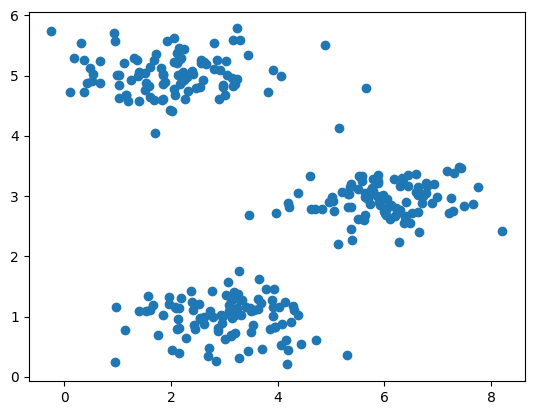

In [2]:
data = sio.loadmat("ex7data2.mat")
X = data["X"]
plt.plot(X[:, 0], X[:, 1], 'o')

### Implementing _K_-Means

The algorithm consists of two parts:
1. Assign each data point to the closest centroid. $idx_i$ corresponds to $c^{(i)}$, the index of the centroid assigned to example $i$.
2. Compute means based on centroids assignments.

One runs the algorithm for a certain number of iterations. The algorithm will always converge, but not necessarily to the optimal value. Therefore, one should run the algorithm multiple times with different random initalizations and choose the one with the lowest cost function value (distortion). 

**Exercise**: Start by initializing _K_ random centroids for the data.

In [17]:
def initialize_K_centroids(X,K):
    m,n = X.shape
    k_rand = np.ones((K,n))
    k_rand = X[np.random.choice(range(len(X)),K,replace = False),:]
    return k_rand

The following should return three points from the dataset.

In [18]:
initialize_K_centroids(X, 3)

array([[6.27376271, 2.24256036],
       [6.5870565 , 3.37508345],
       [1.12036737, 5.20880747]])

**Exercise**: Implement part 1 of the _K_-means algorithm (cluster assignment step)

In [19]:
# X: ma trận dữ liệu; centroids: chứa các điểm trung tâm
def find_closest_centroids(X, centroids):
    m = len(X)
    c = np.zeros(m)
    for i in range (m):
        distances = np.linalg.norm(X[i]-centroids,axis=1)
        c[i]= np.argmin(distances)
    return c

In [20]:
K = 3
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])
idx = find_closest_centroids(X, initial_centroids)

**Exercise**: Implement part 2 of the _K_-means algorithm (Move centroid step). Make sure it is vectorized.

In [21]:
def compute_means(X,idx,K):
    m,n = X.shape
    centroids = np.zeros((K,n))
    for k in range(K):
        points_belong_k = X[np.where(idx ==k)]
        centroids[k] = np.mean(points_belong_k,axis=0,)
    return centroids

The following code should return approximately:
$$
\begin{bmatrix}
2.428 && 3.158 \\
5.814 && 2.634 \\
7.119 && 3.617 
\end{bmatrix}
$$

In [24]:
centroids = compute_means(X, idx, K)
centroids

array([[2.42830111, 3.15792418],
       [5.81350331, 2.63365645],
       [7.11938687, 3.6166844 ]])

### Running _K_-means

In [25]:
def find_k_means(X, K, max_iters=10, plot=False):
    _, n = X.shape
    centroids = initialize_K_centroids(X, K)
    centroid_history = np.zeros((max_iters, K, n))
    for i in range(max_iters):
        idx = find_closest_centroids(X, centroids)
        centroids = compute_means(X, idx, K)

        if plot:
            centroid_history[i] = centroids
     
    if plot:
        for centroid in range(K):
            # Plot examples for this centroid
            examples = X[np.where(idx == centroid)]
            plt.plot(examples[:, 0], examples[:, 1], 'o')
            
            # Plot centroid history
            history = centroid_history[:, centroid, :]
            plt.plot(history[:, 0], history[:, 1], '-xk')
    
    return centroids, idx

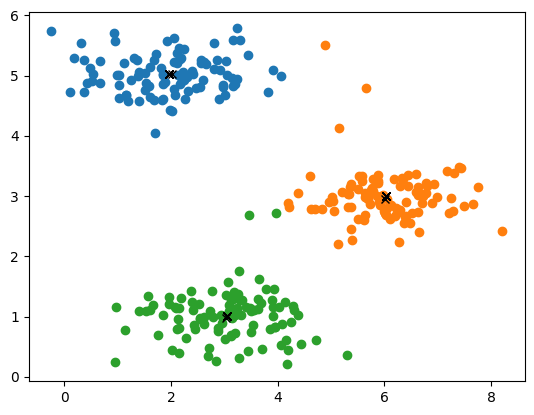

In [26]:
centroids, idx = find_k_means(X, K, plot=True)

### Image compression with _K_-means

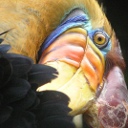

In [30]:
from PIL import Image
image = Image.open('bird_small.png')
X = np.asarray(image) / 255 # range 0 - 1

width, height, depth = X.shape
X = X.reshape((width * height, depth))

image

**Exercise**: Try out different values for *K* and `max_iters`.

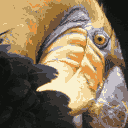

In [32]:
# Run K-means
K = 15
colors, id2 = find_k_means(X, K, max_iters=10)
idx = find_closest_centroids(X, colors)

# Reconstruct image
idx = np.array(idx, dtype=np.uint8)
X_reconstructed = np.array(colors[idx, :] * 255, dtype=np.uint8).reshape((width, height, depth))
compressed_image = Image.fromarray(X_reconstructed)
compressed_image

## Principal Content Analysis
---
In this exercise, you will use principal component analysis (PCA) to perform dimensionality reduction. You will first experiment with an example 2D dataset to get intuition on how PCA works, and then use it on a bigger dataset of 5000 face image dataset.

### Dimension reduction on example dataset

Before using PCA it's important to use feature scaling to make sure every feature 'is of equal importance' when runnig PCA.

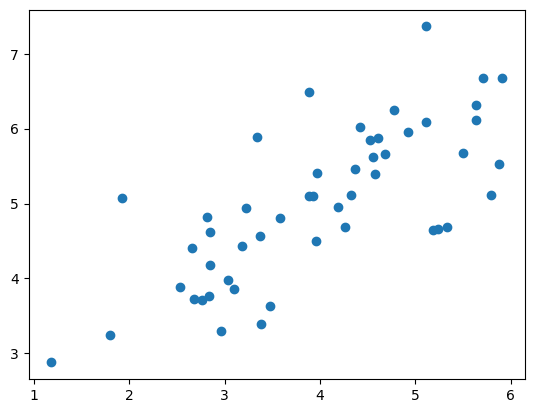

In [142]:
data = sio.loadmat("ex7data1.mat")
X = data["X"]
plt.plot(X[:, 0], X[:, 1], 'o')

In [143]:
def normalize_features(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    return (X-mu)/sigma, mu, sigma

In [144]:
X_norm, mu, sigma = normalize_features(X)

PCA consists of two steps: first you compute the covariance matrix of the data given by:
$$ \Sigma = \frac{1}{m}X^TX$$

. Second you compute the [eigenvectors](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors) of this matrix using numpy: `U, S, V = np.linalg.svd(Sigma)`.

In [145]:
def pca(X):
    m = len(X)
    Sigma = (1/m) * X.T @ X
    U, S, _ = np.linalg.svd(Sigma)
    return U, S

The following code should return approximately $\begin{bmatrix} -0.707 && -0.707\end{bmatrix}$.

In [146]:
U, S = pca(X_norm)
U[0, 0], U[1, 0]

(-0.7071067811865476, -0.7071067811865474)

In [147]:
def project_data(X, U, K):
    Ureduce = U[:, :K]
    z = X @ Ureduce
    return z

The following should return approximately $1.496$.

In [148]:
Z = project_data(X_norm, U, K=1)
Z[0]

array([1.49631261])

In [149]:
Z.shape

(50, 1)

**Exercise**: Implement `recover_data`.

In [150]:
def recover_data(Z, U, K):
    Ureduce = U[:, :K]
    X = Z @ Ureduce.T 
    return X

In [151]:
X_rec[0, 0], X_rec[0, 1]

(252.0, 201.5)

Text(0.5, 1.0, 'Recoverd data')

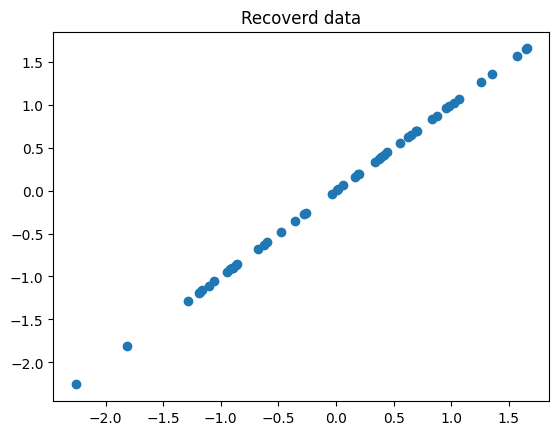

In [152]:
X_rec = recover_data(Z, U, K=1)
plt.plot(X_rec[:, 0], X_rec[:, 1], 'o')
plt.title("Recoverd data")

### PCA on faces
In this part of the exercise, you will run PCA on face images to see how it can be used in practice for dimension reduction.

In [153]:
data = sio.loadmat("ex7faces.mat")
X = data["X"]

In [154]:
def display_samples(X):
    rows = 4
    size = int(np.sqrt(len(X.T)))
    num_samples = rows ** 2
    samples = X[:num_samples]
    display_img = Image.new('RGB', (rows*32, rows*32))

    # loop over the images, turn them into a PIL image
    i = 0
    for col in range(rows):
        for row in range(rows):
            array = samples[i]
            array = ((array / max(array)) * 255).reshape((size, size)).transpose() # redistribute values
            img = Image.fromarray(array + 128)
            display_img.paste(img, (col*32, row*32))
            i += 1

    # present display_img
    plt.imshow(display_img, interpolation='nearest')

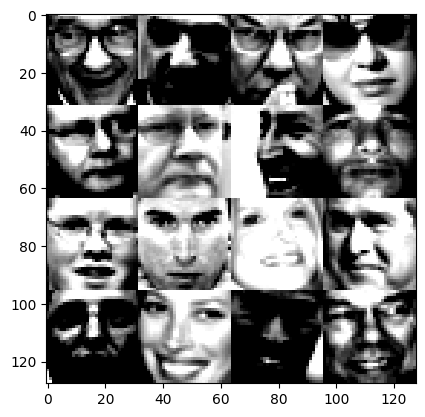

In [155]:
display_samples(X)

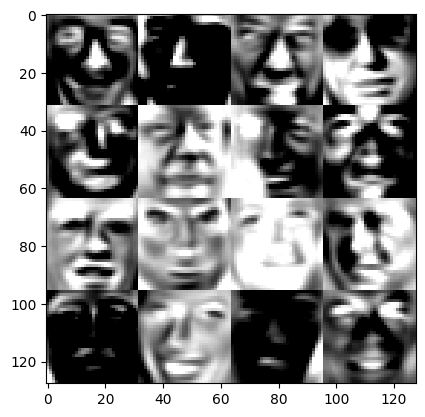

In [156]:
K = 100
X_norm, mu, sigma = normalize_features(X)
U, S = pca(X_norm)
Z = project_data(X_norm, U, K)
X_rec = recover_data(Z, U, K)
display_samples(X_rec)